In [1]:
import torch
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import numpy as np
import time
from utils import MirrorDescent, barycentric_to_cartesian, entropic_mirror_map, test_loop

Elapsed time: 14.82 seconds
Loss < 1.0 reached at iteration 0
Loss < 0.1 reached at iteration 2560
Loss < 0.01 reached at iteration 3792
Loss < 0.001 reached at iteration 4950
Loss < 0.0001 reached at iteration 6103
Loss < 1e-05 reached at iteration 7256


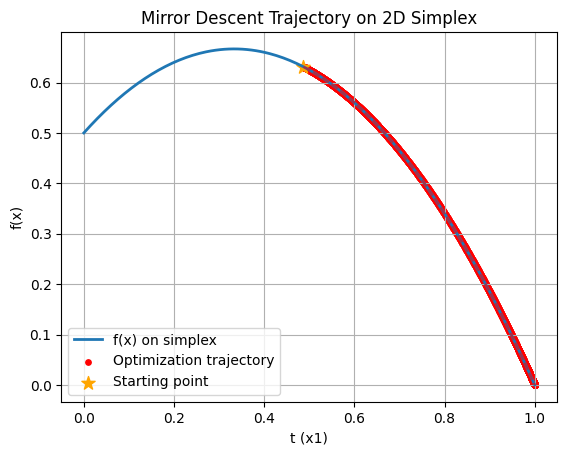

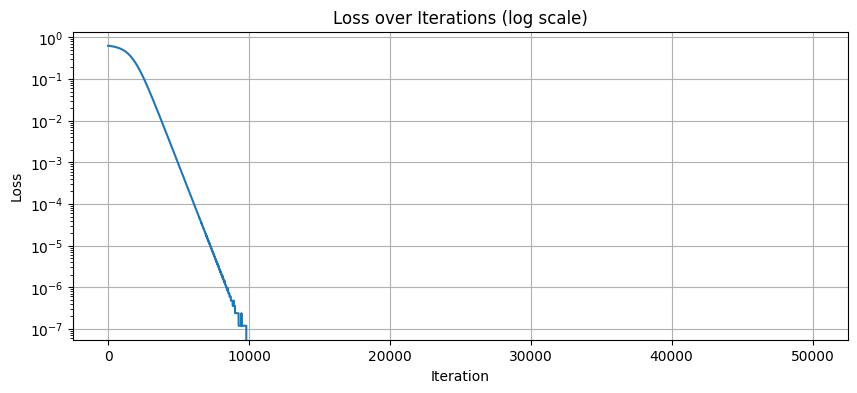

In [28]:
# concave quadratic function
Q = torch.tensor([[-2.0, -1.0],
                  [-1.0, -3.0]])
b = torch.tensor([1.0, 2.0])

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

def stochastic_quadratic(x):
    noise = torch.randn_like(x) * 0.00
    return quadratic(x + noise)

torch.manual_seed(10)
x_init = torch.rand(2)
x_init = x_init / x_init.sum()
trajectory, losses = test_loop(entropic_mirror_map, x_init, quadratic, stochastic_quadratic)

t_iters = trajectory[:, 0]

f_iters = []
for x_np in trajectory:
    x_torch = torch.tensor(x_np, dtype=torch.float32)
    f_iters.append(quadratic(x_torch).item())

t_vals = np.linspace(0, 1, 200)
f_vals = []
for t in t_vals:
    x = torch.tensor([t, 1 - t], dtype=torch.float32)
    f_vals.append(quadratic(x).item())

# Plot the function on simplex
plt.plot(t_vals, f_vals, label='f(x) on simplex', linewidth=2)
# Plot the trajectory of iterates
plt.scatter(t_iters, f_iters, color='red', label='Optimization trajectory', s=15)
plt.scatter(x_init[0], quadratic(x_init), color='orange', marker='*', label='Starting point', s=100)
plt.plot(t_iters, f_iters, color='red', linestyle='dashed', alpha=0.6)

plt.xlabel('t (x1)')
plt.ylabel('f(x)')
plt.title('Mirror Descent Trajectory on 2D Simplex')
plt.legend()
plt.grid(True)
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations (log scale)")
plt.grid(True)
plt.show()

Elapsed time: 15.07 seconds
Loss < 1.0 reached at iteration 755
Loss < 0.1 reached at iteration 1090
Loss < 0.01 reached at iteration 1106
Loss < 0.001 reached at iteration 1106
Loss < 0.0001 reached at iteration 1106
Loss < 1e-05 reached at iteration 1106


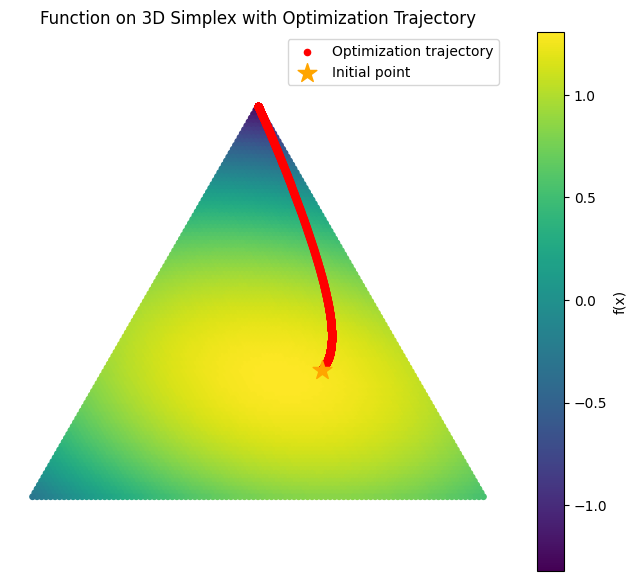

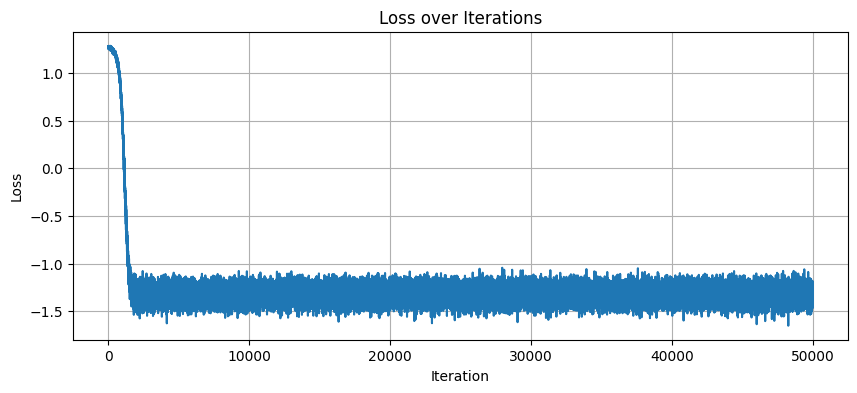

In [33]:
# concave quadratic function
Q = torch.tensor([[-10.0362,  -4.7471,   0.5615],
        [ -4.7471,  -4.6708,   1.4179],
        [  0.5615,   1.4179,  -2.9237]])
b = torch.tensor([4.7412, 2.8671, 0.1415])

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

def stochastic_quadratic(x):
    noise = torch.randn_like(x) * 0.01
    return quadratic(x + noise)

x_init = torch.rand(3)
x_init = x_init / x_init.sum()
trajectory, losses = test_loop(entropic_mirror_map, x_init, quadratic, stochastic_quadratic)


# Create a fine grid of points in the simplex
n_points = 100
x_list = []
for i in range(n_points+1):
    for j in range(n_points+1 - i):
        k = n_points - i - j
        x1 = i / n_points
        x2 = j / n_points
        x3 = k / n_points
        x_list.append([x1, x2, x3])
x_arr = np.array(x_list)

# Compute function values at those points
f_vals = []
for x_np in x_arr:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    f_vals.append(quadratic(x_t).item())
f_vals = np.array(f_vals)

# Convert barycentric coords to cartesian for plotting
xy = barycentric_to_cartesian(x_arr)

# Plot filled contour (scatter colored by f(x))
plt.figure(figsize=(8,7))
sc = plt.scatter(xy[:,0], xy[:,1], c=f_vals, cmap='viridis', s=15)
plt.colorbar(sc, label='f(x)')

# Plot optimization trajectory (trajectory is array Nx3)
# Convert trajectory points to cartesian and plot
trajectory_xy = barycentric_to_cartesian(trajectory)
trajectory_f = []
for x_np in trajectory:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    trajectory_f.append(quadratic(x_t).item())

plt.scatter(trajectory_xy[:, 0], trajectory_xy[:, 1], c='red', marker='o', s=20, label='Optimization trajectory')
x_init_xy = barycentric_to_cartesian(np.array([x_init.numpy()]))[0]
plt.scatter(x_init_xy[0], x_init_xy[1], color='orange', marker='*', s=200, label='Initial point')

plt.title('Function on 3D Simplex with Optimization Trajectory')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.grid(True)
plt.show()

Completed 100 runs in 152.74 seconds


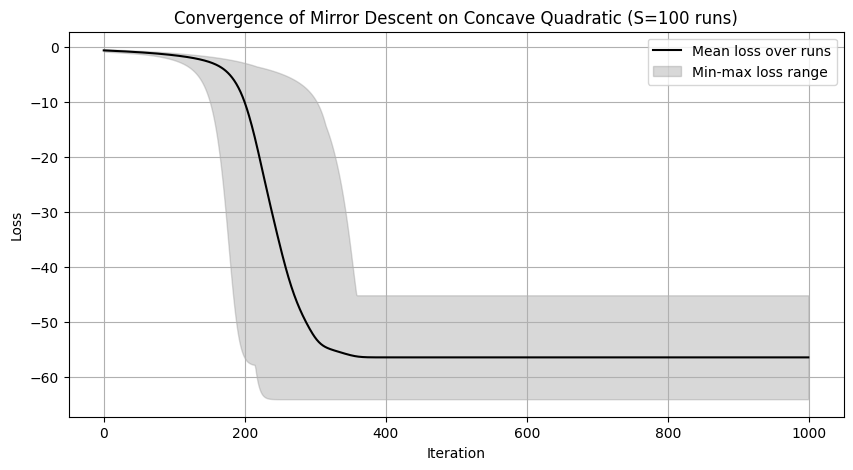

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

d = 100

# Create a random symmetric negative definite matrix Q
A = torch.randn(d, d)
Q = -A @ A.T
b = torch.randn(d)

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

def stochastic_gradient(x, noise_scale=0.1, t=1):
    true_grad = grad_quadratic(x)
    noise = torch.randn_like(x) * (noise_scale / np.sqrt(t))
    return true_grad + noise

# MirrorDescent class (simple entropic mirror descent)
class MirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, noise_scale=0.1):
        defaults = dict(lr=lr, noise_scale=noise_scale)
        super().__init__(params, defaults)

    def step(self, i):
        for group in self.param_groups:
            lr = group['lr']
            noise_scale = group['noise_scale']
            for p in group['params']:
                grad = stochastic_gradient(p.data, noise_scale, i+1)
                z = torch.log(p.data + 1e-8)  # ensure numerical stability
                z_new = z - lr * grad
                p.data = torch.exp(z_new)
                p.data /= p.data.sum()
                
class LazyMirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, noise_scale=0.1, beta=0.9):
        defaults = dict(lr=lr, beta=beta, noise_scale=noise_scale)
        super().__init__(params, defaults)
        self.state['grad_avg'] = None

    def step(self, i):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            noise_scale = group['noise_scale']
            for p in group['params']:
                grad = stochastic_gradient(p.data, noise_scale, i+1)

                # Lazy update: momentum-like average of gradients
                state = self.state
                if state['grad_avg'] is None:
                    state['grad_avg'] = grad.clone()
                else:
                    state['grad_avg'] = beta * state['grad_avg'] + (1 - beta) * grad

                z = torch.log(p.data + 1e-8)
                z_new = z - lr * state['grad_avg']
                p.data = torch.exp(z_new)
                p.data /= p.data.sum()

# Number of independent runs
S = 100
max_iters = 1000
lr = 2e-3
tolerance = 1e-5

# Store all losses for all runs
all_losses = np.zeros((S, max_iters))

start_time = time.time()

for s in range(S):
    torch.manual_seed(s)  # seed for reproducibility

    # Initialize x randomly on simplex
    x_init = torch.rand(d)
    x_init /= x_init.sum()
    x = torch.nn.Parameter(x_init)

    optimizer = LazyMirrorDescent([x], lr=lr)
    
    losses = []
    for i in range(max_iters):
        optimizer.zero_grad()
        loss = stochastic_quadratic(x)
        loss.backward()
        optimizer.step(i)

        losses.append(quadratic(x).item())
        grad_norm = torch.norm(x.grad.detach())
        if grad_norm < tolerance:
            break

    # Fill all_losses row with losses, pad with last loss if early stopped
    if len(losses) < max_iters:
        losses += [losses[-1]] * (max_iters - len(losses))
    all_losses[s, :] = losses[:max_iters]

end_time = time.time()

print(f"Completed {S} runs in {end_time - start_time:.2f} seconds")

# Compute statistics
mean_loss = all_losses.mean(axis=0)
min_loss = all_losses.min(axis=0)
max_loss = all_losses.max(axis=0)

# Plot mean + shaded best/worst loss curves (like Fig. 5)
plt.figure(figsize=(10, 5))
plt.plot(mean_loss, color='black', label='Mean loss over runs')
plt.fill_between(range(max_iters), min_loss, max_loss, color='gray', alpha=0.3, label='Min-max loss range')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Convergence of Mirror Descent on Concave Quadratic (S=100 runs)')
plt.legend()
plt.grid(True)
plt.show()

Elapsed time: 15.33 seconds


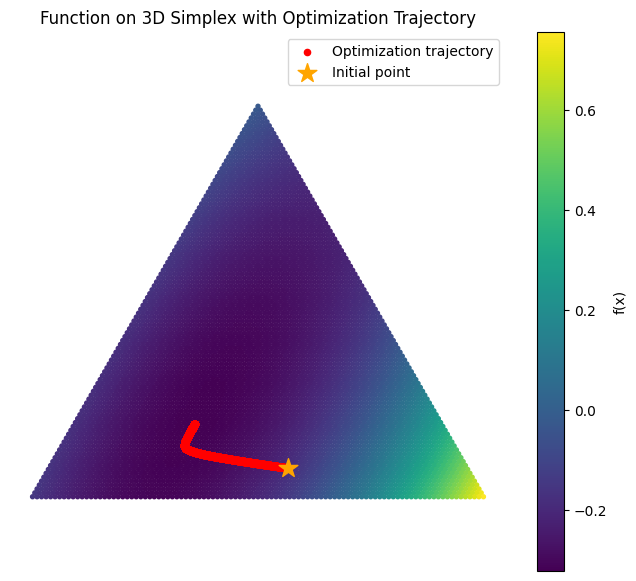

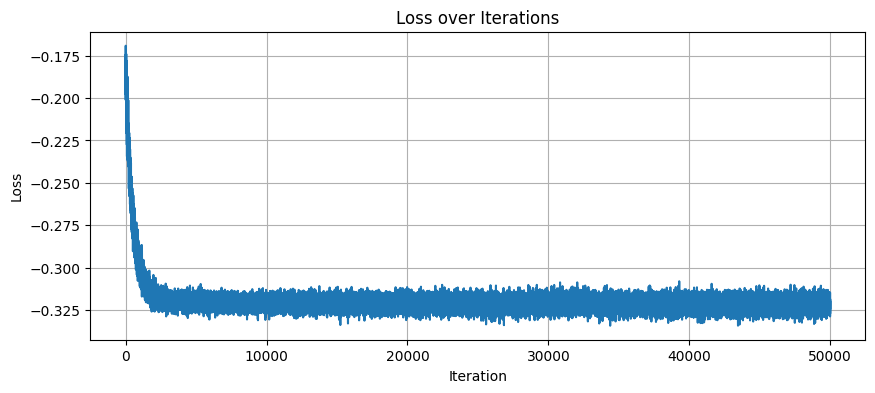

In [ ]:
# Q indefinite

Q = torch.tensor([[1.59013784, -0.84236252,  0.60832001],
        [-0.84236252,  0.8312001 , -1.5313728 ],
        [ 0.60832001, -1.5313728 ,  0.28483157]])
b = torch.tensor([-0.94522481,  0.34093502, -0.1653904 ])

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

def stochastic_quadratic(x):
    noise = torch.randn_like(x) * 0.01
    return quadratic(x + noise)

# Optimization variable
# torch.manual_seed(10)
x_init = torch.rand(3)
x_init = x_init / x_init.sum()
trajectory, losses = test_loop(entropic_mirror_map, x_init, quadratic, stochastic_quadratic, thresholds=False)

# Create a fine grid of points in the simplex
n_points = 100
x_list = []
for i in range(n_points+1):
    for j in range(n_points+1 - i):
        k = n_points - i - j
        x1 = i / n_points
        x2 = j / n_points
        x3 = k / n_points
        x_list.append([x1, x2, x3])
x_arr = np.array(x_list)

# Compute function values at those points
f_vals = []
for x_np in x_arr:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    f_vals.append(quadratic(x_t).item())
f_vals = np.array(f_vals)

# Convert barycentric coords to cartesian for plotting
xy = barycentric_to_cartesian(x_arr)

# Plot filled contour (scatter colored by f(x))
plt.figure(figsize=(8,7))
sc = plt.scatter(xy[:,0], xy[:,1], c=f_vals, cmap='viridis', s=8)
plt.colorbar(sc, label='f(x)')

# Plot optimization trajectory (trajectory is array Nx3)
# Convert trajectory points to cartesian and plot
trajectory_xy = barycentric_to_cartesian(trajectory)
trajectory_f = []
for x_np in trajectory:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    trajectory_f.append(quadratic(x_t).item())

plt.scatter(trajectory_xy[:, 0], trajectory_xy[:, 1], c='red', marker='o', s=20, label='Optimization trajectory')
x_init_xy = barycentric_to_cartesian(np.array([x_init.numpy()]))[0]
plt.scatter(x_init_xy[0], x_init_xy[1], color='orange', marker='*', s=200, label='Initial point')

plt.title('Function on 3D Simplex with Optimization Trajectory')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.grid(True)
plt.show()